#

# Interpretable ML
# Nathan Bush


Note: The exploratory data analysis (EDA) is done throughout the document. I check assumptions when we reach them as some assumptions can only be checked after fitting the model (mostly done in the logistic regression part)

As such, I have broken this into four sections, one for each model, and then the conclusion.



In [16]:
# Install required packages
!pip install numpy pandas matplotlib scikit-learn \
             black kagglehub[pandas-datasets] \
             statsmodels seaborn pygam


In [17]:
# --- Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.api as sms
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, linear_reset
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import OLSInfluence, variance_inflation_factor

In [18]:
# Pretty printing
pd.set_option("display.max_columns", 200)
plt.rcParams["figure.figsize"] = (7, 5)

# The dataset contains a CSV named exactly like this:
csv_name = "WA_Fn-UseC_-Telco-Customer-Churn.csv"

df = kagglehub.dataset_load(
    KaggleDatasetAdapter.PANDAS,
    "blastchar/telco-customer-churn",
    path=csv_name,  # must include a filename with an extension
    pandas_kwargs={"low_memory": False}
)
df.head(4)


Using Colab cache for faster access to the 'telco-customer-churn' dataset.


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


# linear:


Linearity – Violated, since churn is a binary variable.

A linear regression model is not appropriate for this outcome, because the relationship between predictors and a binary target can never be properly captured by a straight line. In practice, OLS will always misfit here. Strictly speaking, it’s not necessary to check the other assumptions, but since you asked, here’s the model the rest of them

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# --- Prep ---
df = df.copy()

# target + numeric fix
df["Churn_num"] = df["Churn"].map({"Yes": 1, "No": 0}).astype(float)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# drop rows where key fields are missing
df = df.dropna(subset=["Churn_num", "TotalCharges"])

# optional: drop id
if "customerID" in df.columns:
    df = df.drop(columns=["customerID"])

# --- Recode service columns to avoid perfect collinearity ---
svc_cols = [
    "OnlineSecurity","OnlineBackup","DeviceProtection",
    "TechSupport","StreamingTV","StreamingMovies","MultipleLines"
]
for c in svc_cols:
    df[c + "_bin"] = (df[c] == "Yes").astype(int)

# simple yes/no’s
yn_cols = ["Partner","Dependents","PaperlessBilling","PhoneService"]
for c in yn_cols:
    df[c + "_bin"] = (df[c] == "Yes").astype(int)

# Gender to 0/1
df["Male"] = (df["gender"] == "Male").astype(int)

# Categorical variables
df["Contract"] = df["Contract"].astype("category")
df["InternetService"] = df["InternetService"].astype("category")
df["PaymentMethod"] = df["PaymentMethod"].astype("category")

# --- Train/test split (80/20) ---
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# --- Formula ---
formula = (
    "Churn_num ~ "
    "SeniorCitizen + tenure + MonthlyCharges + TotalCharges + "
    "Male + Partner_bin + Dependents_bin + PaperlessBilling_bin + "
    "PhoneService_bin + MultipleLines_bin + "
    "OnlineSecurity_bin + OnlineBackup_bin + DeviceProtection_bin + TechSupport_bin + "
    "StreamingTV_bin + StreamingMovies_bin + "
    "C(Contract) + C(InternetService) + C(PaymentMethod)"
)

# Fit OLS on train set
fit = smf.ols(formula=formula, data=train_df).fit()
print(fit.summary())
ols_model = fit


                            OLS Regression Results                            
Dep. Variable:              Churn_num   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.288
Method:                 Least Squares   F-statistic:                     100.1
Date:                Mon, 15 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:58:26   Log-Likelihood:                -2417.5
No. Observations:                5625   AIC:                             4883.
Df Residuals:                    5601   BIC:                             5042.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                  coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

# Performance

The model only explains about 29% of the variation in churn. Since churn is a yes/no outcome, that’s a strong sign this linear regression is a poor choice.

Assumptions

Key assumptions of linear regression (like normality of residuals, constant variance, and low correlation among predictors) are not satisfied here. Because of this, the model’s coefficients and tests can’t be trusted and no interpretations are made (see below for this)
- For example, the output shows that having Fiber optic InternetService is associated with an increase of 0.2735 in the predicted churn value (holding all else constant). However, because this is a linear model applied to a binary outcome, the predictions can fall outside the 0–1 range, so interpreting this as an exact change in probability is not appropriate and as such is really not useful

Conclusion

This linear regression doesn’t fit the data well and shouldn’t be used for interpretation. A more suitable approach, like logistic regression, is needed for binary outcomes.

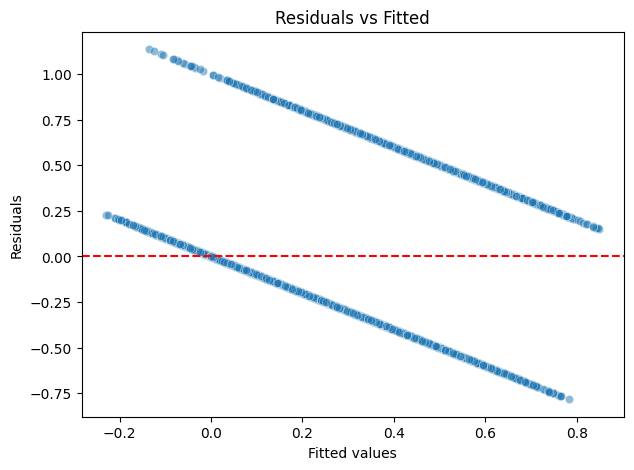

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

residuals = fit.resid
fitted = fit.fittedvalues

plt.figure(figsize=(7,5))
sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted")
plt.show()


Homoscedasticity (constant variance of residuals)
The residual plot shows a clear pattern (two distinct lines) instead of random scatter, which means your model should not be used for this.

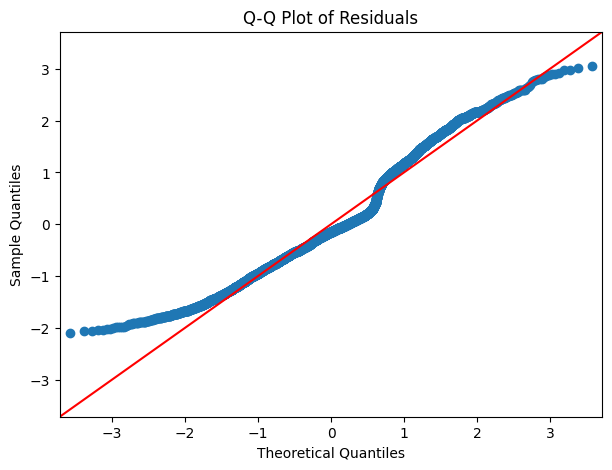

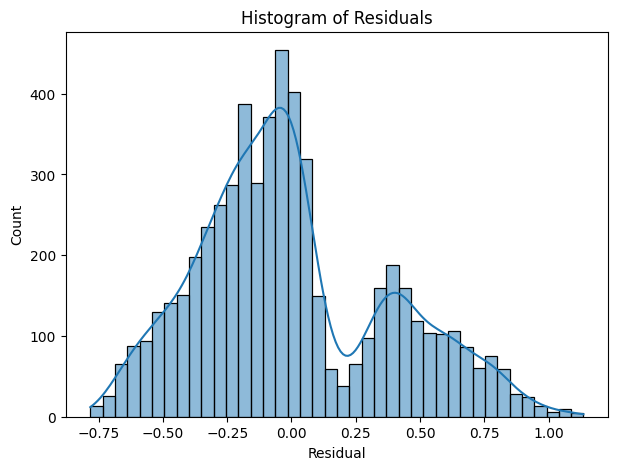

In [21]:
import statsmodels.api as sm

sm.qqplot(residuals, line="45", fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()

plt.figure(figsize=(7,5))
sns.histplot(residuals, kde=True, bins=40)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.show()


Normality of residuals
violated The histogram is bimodal, and the Q–Q plot deviates strongly from the diagonal.

In [22]:
# --- VIFs on the training design matrix (to inspect multicollinearity) ---
y_mat, X_mat = dmatrices(formula, data=train_df, return_type="dataframe")
vif = pd.DataFrame({
    "feature": X_mat.columns,
    "VIF": [variance_inflation_factor(X_mat.values, i) for i in range(X_mat.shape[1])]
}).sort_values("VIF", ascending=False)

print(vif.head(4))


                              feature         VIF
10                     MonthlyCharges  875.944051
0                           Intercept  632.268655
3   C(InternetService)[T.Fiber optic]  149.302028
4            C(InternetService)[T.No]  105.613911


Multicollinearity can be “played with” but doesn’t fix the fact that OLS is a bad choice here.

Independence is a design property, not a model problem. One row per customer, so independence is reasonable.

# Logistic Regression

Independence is a design property, not a model problem. One row per customer, so independence is reasonable.

Large sample size is meet with over 7000, so this is meet.

The dependent variable is binary (0/1) so this is meet.

Optimization terminated successfully.
         Current function value: 0.453372
         Iterations 7


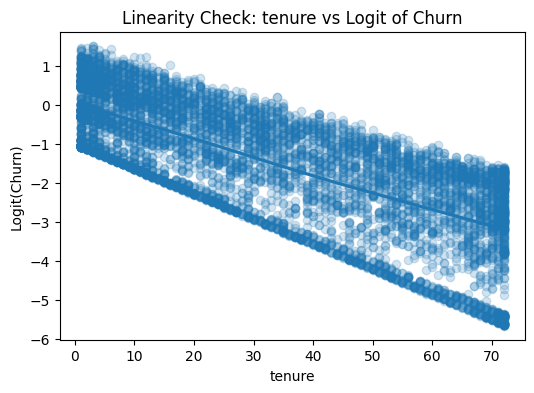

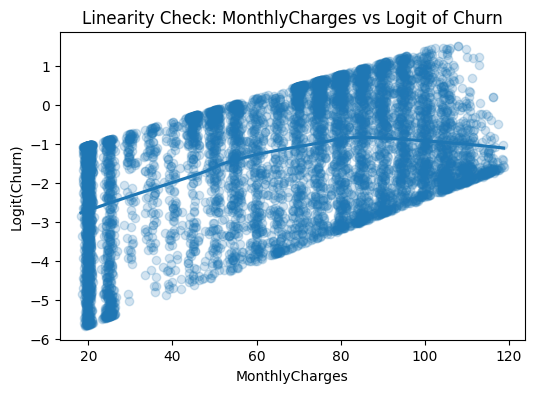

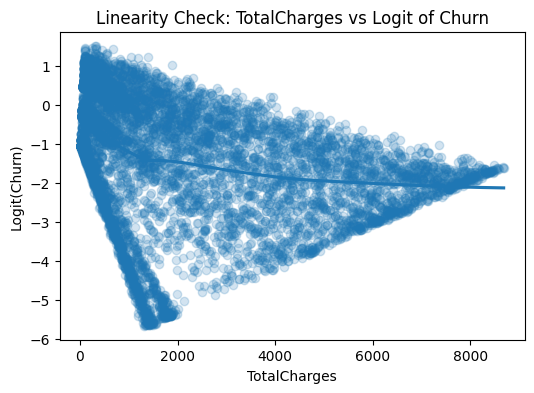

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
continuous_vars = ["tenure", "MonthlyCharges", "TotalCharges"]

# Fit logistic regression
X = sm.add_constant(df[continuous_vars])
y = df["Churn_num"]
logit_model = sm.Logit(y, X).fit()

# Get predicted logits
df["logit"] = logit_model.predict(X)
df["logit"] = np.log(df["logit"] / (1 - df["logit"]))  # convert to log-odds

# Plot each continuous predictor against logit
for col in continuous_vars:
    plt.figure(figsize=(6, 4))
    sns.regplot(x=df[col], y=df["logit"], lowess=True, scatter_kws={'alpha':0.2})
    plt.title(f"Linearity Check: {col} vs Logit of Churn")
    plt.xlabel(col)
    plt.ylabel("Logit(Churn)")
    plt.show()


# Linearity Assumption Summary

- Tenure: Relationship with churn is mostly linear in the logit, so the assumption is satisfied.

- MonthlyCharges: Not fully linear — shows curvature. This variable would ideally be binned or transformed to better capture the relationship.

- TotalCharges: Clearly non-linear, with a “fan-out” pattern. Transformations (e.g., log, splines) would improve fit, though we are leaving it as-is for now.

Overall: The linearity assumption is reasonably met for tenure, but less so for MonthlyCharges and TotalCharges. In practice I would check every var but I will hold off here

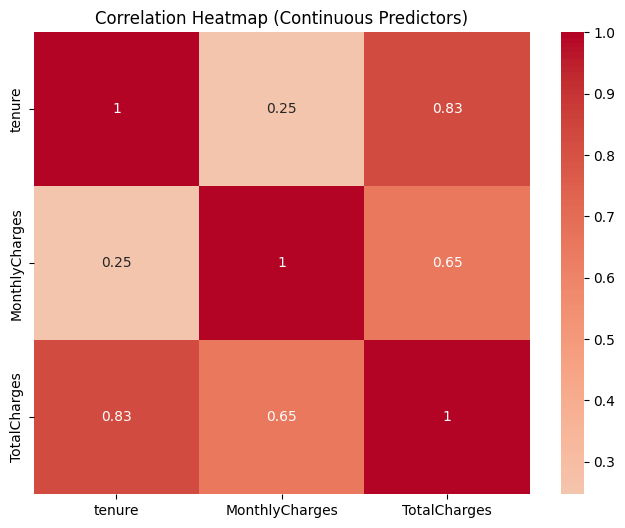

In [24]:
plt.figure(figsize=(8, 6))
sns.heatmap(df[continuous_vars].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Continuous Predictors)")
plt.show()



# Multicollinearity Check  

- **Tenure & TotalCharges:** High correlation (0.83). Potential multicollinearity risk, since TotalCharges is largely derived from tenure.  
- **MonthlyCharges & TotalCharges:** Moderate correlation (0.65).  
- **Tenure & MonthlyCharges:** Low correlation (0.25).  

**Conclusion:** No severe multicollinearity overall, but caution is needed with Tenure and TotalCharges.  


In [25]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import logit
from statsmodels.stats.outliers_influence import variance_inflation_factor
import patsy

# Your formula
formula = (
    "Churn_num ~ "
    "SeniorCitizen + tenure + MonthlyCharges + TotalCharges + "
    "Male + Partner_bin + Dependents_bin + PaperlessBilling_bin + "
    "PhoneService_bin + MultipleLines_bin + "
    "OnlineSecurity_bin + OnlineBackup_bin + DeviceProtection_bin + TechSupport_bin + "
    "StreamingTV_bin + StreamingMovies_bin + "
    "C(Contract) + C(InternetService) + C(PaymentMethod)"
)

# Build design matrices (y, X)
y, X = patsy.dmatrices(formula, data=df, return_type="dataframe")

# Add constant if not already there
if "Intercept" not in X.columns and "const" not in X.columns:
    X = sm.add_constant(X, has_constant="add")

# Compute VIF for each column in X
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                   for i in range(X.shape[1])]

print(vif_data.sort_values("VIF", ascending=False))



                                        feature         VIF
10                               MonthlyCharges  866.089640
0                                     Intercept  629.180624
3             C(InternetService)[T.Fiber optic]  148.500814
4                      C(InternetService)[T.No]  104.213701
16                             PhoneService_bin   34.893857
23                          StreamingMovies_bin   24.156394
22                              StreamingTV_bin   24.080019
11                                 TotalCharges   10.811490
9                                        tenure    7.584453
17                            MultipleLines_bin    7.289761
20                         DeviceProtection_bin    6.924754
19                             OnlineBackup_bin    6.796678
21                              TechSupport_bin    6.476508
18                           OnlineSecurity_bin    6.338349
2                       C(Contract)[T.Two year]    2.652328
6          C(PaymentMethod)[T.Electronic

# multicollinearity 2
The strongest collinearity is between MonthlyCharges, TotalCharges, and tenure (they are mathematically related).

Internet service dummies are also highly collinear (Fiber optic vs No).

Entertainment services (StreamingTV_bin and StreamingMovies_bin) overlap a lot.

Several of the add-on services (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport) are moderately correlated with each other.

# we will adjust the logit as follows to help with multicollinearity

In [26]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import logit

# --- 1. Create derived features on training and test data ---
for d in (train_df, test_df):
    # HasStreaming = 1 if StreamingTV or StreamingMovies is yes
    d["HasStreaming"] = ((d["StreamingTV_bin"] + d["StreamingMovies_bin"]) > 0).astype(int)

    # AddOnCount = number of add-on services subscribed
    add_on_vars = ["OnlineSecurity_bin", "OnlineBackup_bin",
                   "DeviceProtection_bin", "TechSupport_bin"]
    d["AddOnCount"] = d[add_on_vars].sum(axis=1)

# --- 2. Define formula ---
formula = (
    "Churn_num ~ "
    "SeniorCitizen + tenure + MonthlyCharges + "
    "Male + Partner_bin + Dependents_bin + PaperlessBilling_bin + "
    "PhoneService_bin + MultipleLines_bin + "
    "AddOnCount + "
    "HasStreaming + "
    "C(Contract) + C(InternetService) + C(PaymentMethod)"
)

# --- 3. Fit logistic regression on training set ---
model_logit = logit(formula, data=train_df).fit()
print(model_logit.summary())


Optimization terminated successfully.
         Current function value: 0.413687
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:              Churn_num   No. Observations:                 5625
Model:                          Logit   Df Residuals:                     5606
Method:                           MLE   Df Model:                           18
Date:                Mon, 15 Sep 2025   Pseudo R-squ.:                  0.2855
Time:                        02:58:40   Log-Likelihood:                -2327.0
converged:                       True   LL-Null:                       -3257.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                  coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
Intercept                                 


# Logistic Regression Results – Churn

## Model fit

Pseudo R² = 0.29, which indicates moderate explanatory power for a churn model.

Likelihood ratio test is highly significant (p < 0.001), so the model as a whole improves over a null model.

### Variables with little or no evidence

Gender, Partner, MultipleLines, and several payment methods (Credit card, Mailed check) as well as InternetService: Fiber optic show weak or borderline effects once other variables are controlled for. HasStreaming is borderline as well. These may not be useful predictors in this specification.

### Notable effects

Contract: Two-year → coef = –1.37 → odds ratio ≈ 0.25 → customers on two-year contracts have about 75% lower odds of churning than month-to-month customers.

Contract: One-year → coef = –0.78 → odds ratio ≈ 0.46 → customers on one-year contracts have about 54% lower odds of churning than month-to-month customers.

InternetService: No Internet → coef = 0.47 → odds ratio ≈ 1.60 → customers without internet service have about 60% higher odds of churning than DSL customers.

Tenure → coef = –0.03 → odds ratio per month ≈ 0.97 → each additional month with the company reduces the odds of churning by about 3%.

AKA: Customers on longer contracts are much less likely to leave (Churn), while those without internet service are more likely to churn.

# GAMs

# Assumptions  
Assumptions that have not already been check are difficult to check prior to fitting GAMs.
We proceed under the assumption they are met, and will validate them by examining the model results and diagnostics.  


In [27]:
import pandas as pd
import numpy as np
from pygam import LogisticGAM, s, f
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score

# --- 1) Prep data ---
for d in (train_df, test_df):
    d["Churn_num"] = d["Churn"].map({"Yes": 1, "No": 0}).astype(int)
    d["TotalCharges"] = pd.to_numeric(d["TotalCharges"], errors="coerce")

# Drop rows with missing key fields (on train only, so evaluation set is untouched)
train_df = train_df.dropna(subset=["TotalCharges", "Churn_num"])
test_df = test_df.dropna(subset=["TotalCharges", "Churn_num"])

# --- 2) Encode categorical features (fit on train, apply to both) ---
categoricals = ["Contract", "InternetService", "PaymentMethod", "gender",
                "Partner", "Dependents", "PaperlessBilling"]

encoders = {col: LabelEncoder().fit(train_df[col]) for col in categoricals}

for d in (train_df, test_df):
    for col, le in encoders.items():
        d[col + "_enc"] = le.transform(d[col])

# --- 3) Build design matrices ---
X_train = train_df[[
    "tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen",
    "Contract_enc", "InternetService_enc", "PaymentMethod_enc",
    "gender_enc", "Partner_enc", "Dependents_enc", "PaperlessBilling_enc"
]].values
y_train = train_df["Churn_num"].values

X_test = test_df[[
    "tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen",
    "Contract_enc", "InternetService_enc", "PaymentMethod_enc",
    "gender_enc", "Partner_enc", "Dependents_enc", "PaperlessBilling_enc"
]].values
y_test = test_df["Churn_num"].values

# --- 4) Define GAM structure and fit on train ---
gam = LogisticGAM(
    s(0) +  # tenure
    #s(1) +  # MonthlyCharges is fully corrlect so  remove
    s(2) +  # TotalCharges
    f(3) +  # SeniorCitizen
    f(4) +  # Contract
    f(5) +  # InternetService
    f(6) +  # PaymentMethod
    f(7) +  # gender
    f(8) +  # Partner
    f(9) +  # Dependents
    f(10)   # PaperlessBilling
).fit(X_train, y_train)

# --- 5) Summary ---
print(gam.summary())






LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                       36.66
Link Function:                        LogitLink Log Likelihood:                                 -2298.3811
Number of Samples:                         5625 AIC:                                             4670.0822
                                                AICc:                                            4670.6034
                                                UBRE:                                               2.8355
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.2943
Feature Function                  Lam

/tmp/ipython-input-2932586385.py:57: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


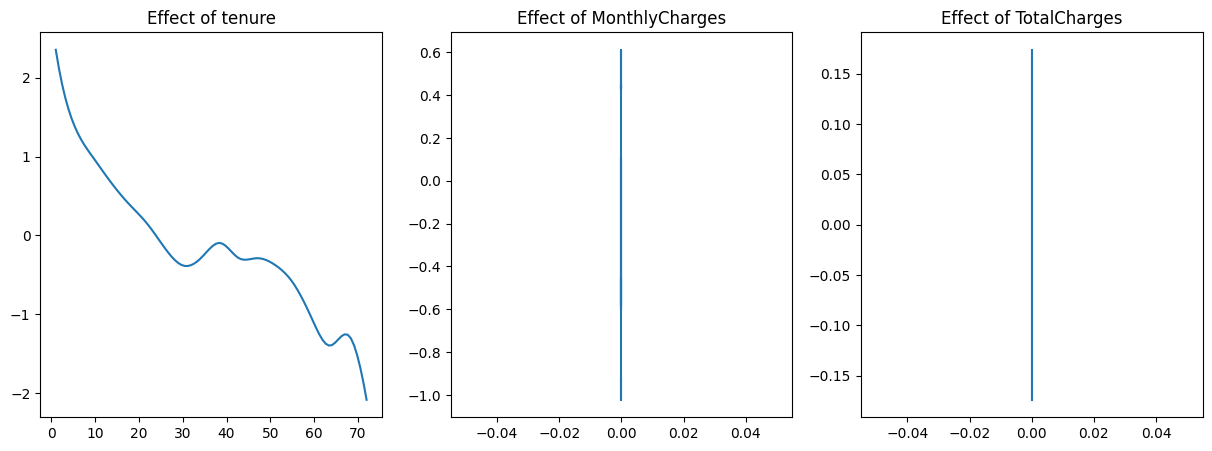

In [28]:
# --- 6) Plots for smooth terms ---
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, label in enumerate(["tenure", "MonthlyCharges", "TotalCharges"]):
    XX = gam.generate_X_grid(term=i)
    axs[i].plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    axs[i].set_title(f"Effect of {label}")
plt.show()

At very low tenure (new customers), churn risk is highest.

As tenure grows, the effect steadily drops, meaning long-term customers are less likely to churn.

# Evaluation

In [29]:
y_pred_prob = gam.predict_mu(X_test)  # probabilities
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")


Accuracy: 0.791
F1 Score: 0.556


In [30]:
from sklearn.metrics import accuracy_score, f1_score
# --- 4. Evaluate on test set ---
y_test = test_df["Churn_num"]
# use the same variable name as the fitted model
y_pred_prob = model_logit.predict(test_df)  # probabilities
y_pred = (y_pred_prob >= 0.5).astype(int)
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"\nAccuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")



Accuracy: 0.794
F1 Score: 0.571


In [31]:
from sklearn.metrics import accuracy_score, f1_score

# --- Evaluate OLS model on test set ---
y_test = test_df["Churn_num"]
y_pred_prob = ols_model.predict(test_df)  # predictions are continuous

# Threshold at 0.5 for classification
y_pred = (y_pred_prob >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"\nAccuracy: {acc:.3f}")
print(f"F1 Score: {f1:.3f}")



Accuracy: 0.792
F1 Score: 0.557



### Model Comparison

To keep things simple, we evaluated all models using **accuracy** and **F1 score** on the test set.

* **Logistic Regression (Logit)**
  Logistic regression achieved the best performance across both metrics. It also has the benefit of being highly interpretable, which makes it easier for the telecommunications company to understand the factors driving churn. This combination of accuracy and interpretability makes it the strongest candidate.

* **Linear Regression (OLS)**
  While the linear model performed reasonably well, it is not reliable for binary classification tasks because its assumptions are not met in this setting. As a result, predictions and interpretations from OLS are less trustworthy, even if accuracy is not far behind logistic regression.

* **Generalized Additive Model (GAM)**
  The GAM did not outperform logistic regression and comes with reduced interpretability. While it may offer some flexibility and with more tuning my work better, the trade-off between complexity and interpretability does not seem worthwhile in this case.

### Recommendation

Overall, **logistic regression** is the recommended model. It balances strong predictive performance with interpretability, making it the most practical and actionable choice for addressing customer churn.

From that model I can say  Customers on longer contracts are much less likely to leave (Churn), while those without internet service are more likely to churn.
